In [1]:
!pip install pandas matplotlib seaborn plotly yfinance scikit-learn statsmodels tensorflow keras prophet streamlit altair

Defaulting to user installation because normal site-packages is not writeable


In [32]:
!pip install streamlit pyngrok

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [5]:
data = yf.download('TSLA', start='2015-01-01', end='2024-01-01')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.dropna(inplace=True)
data.index = pd.to_datetime(data.index)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


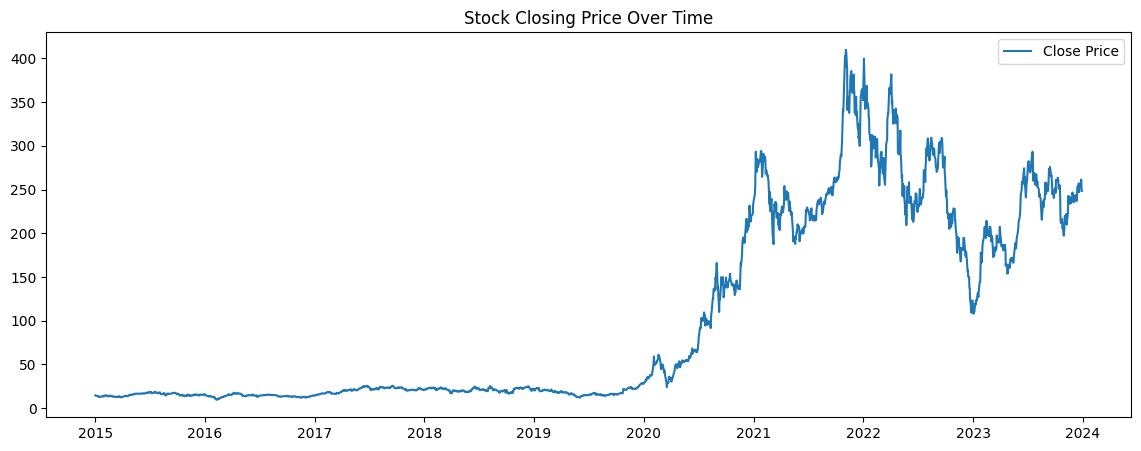

In [6]:
# Line plot
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Close Price')
plt.title('Stock Closing Price Over Time')
plt.legend()
plt.show()


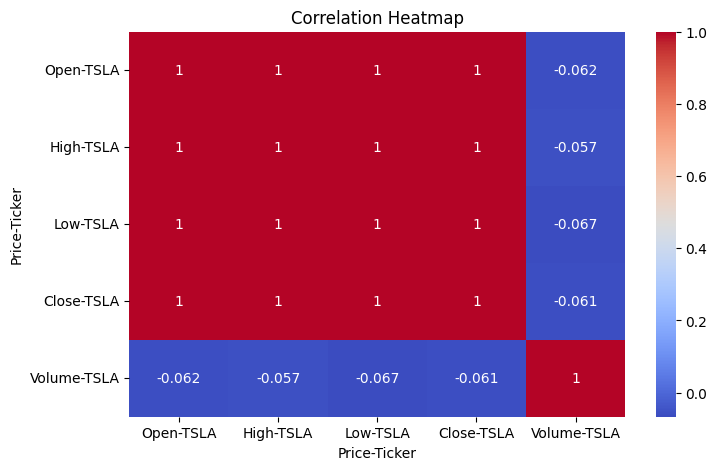

In [7]:
# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [8]:
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)
X = data.drop('Target', axis=1)
y = data['Target']
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

supervised

In [9]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"{name} MAE: {mean_absolute_error(y_test, pred):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.2f}")


Linear Regression MAE: 6.44, RMSE: 8.67
Decision Tree MAE: 10.18, RMSE: 13.49


unsupervised

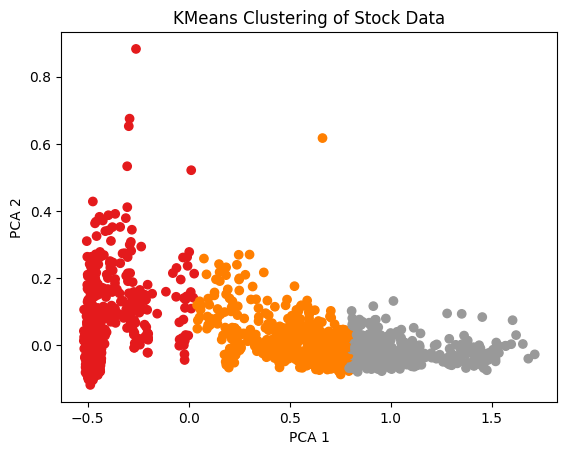

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# KMeans Clustering
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(pca_data)

# Plot clusters
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='Set1')
plt.title('KMeans Clustering of Stock Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


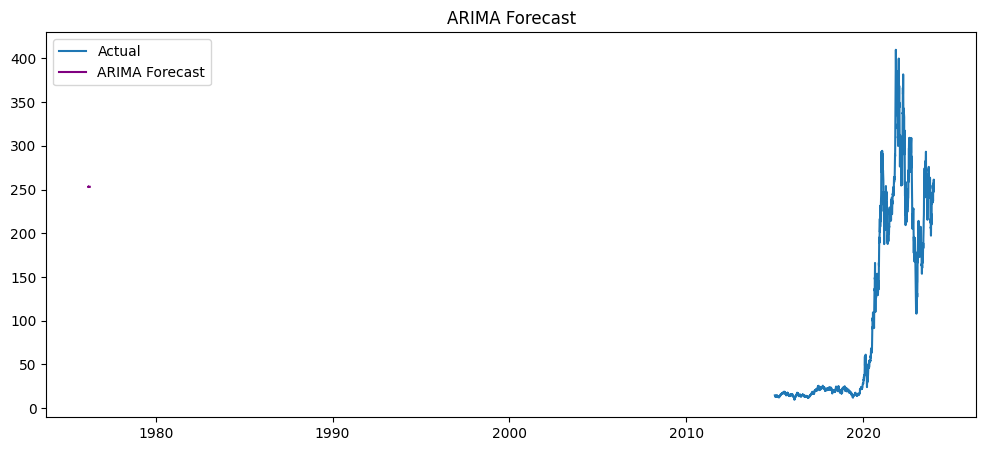

In [11]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(data['Close'], order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=30)

plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Actual')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='purple')
plt.title("ARIMA Forecast")
plt.legend()
plt.show()

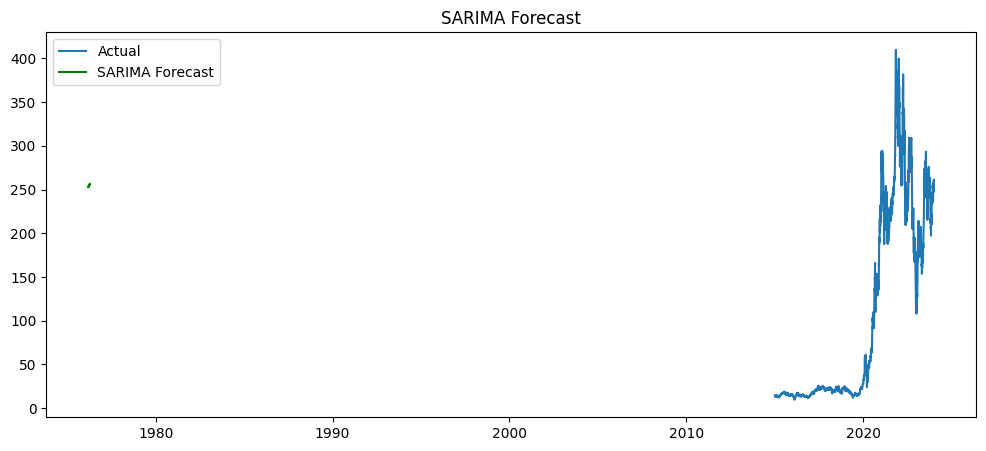

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(data['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(30)

plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Actual')
plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title("SARIMA Forecast")
plt.legend()
plt.show()


In [13]:
prophet_df = data[['Close']].copy().reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')
prophet_df.dropna(inplace=True)
print(prophet_df.columns)
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

Index(['ds', 'y'], dtype='object')


20:20:27 - cmdstanpy - INFO - Chain [1] start processing
20:20:28 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
prophet_df = data[['Close']].copy()
prophet_df.reset_index(inplace=True)
print(prophet_df.columns)


MultiIndex([( 'Date',     ''),
            ('Close', 'TSLA')],
           names=['Price', 'Ticker'])


20:20:29 - cmdstanpy - INFO - Chain [1] start processing
20:20:30 - cmdstanpy - INFO - Chain [1] done processing


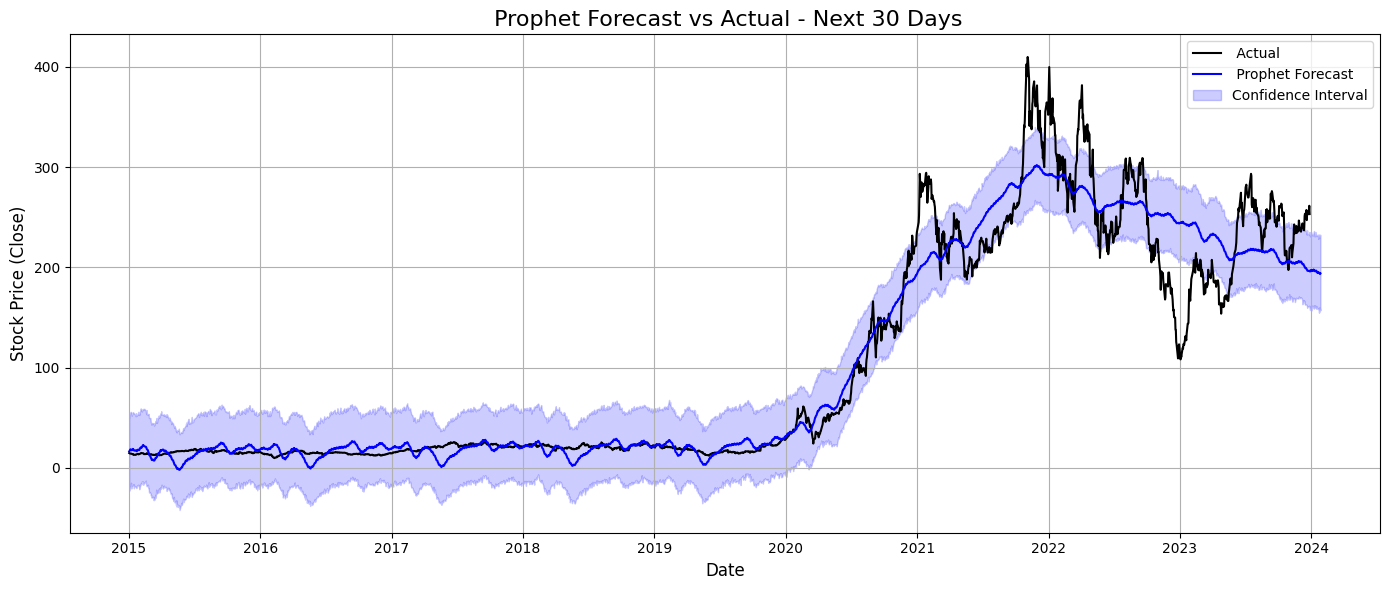

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Flatten MultiIndex if any
data.columns = data.columns.get_level_values(0)

# Prepare data for Prophet
prophet_df = data[['Close']].copy().reset_index()
prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Ensure correct formats
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')
prophet_df.dropna(inplace=True)

# Train Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Create future dates and forecast
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Plot custom chart with labels
plt.figure(figsize=(14, 6))

# Actual
plt.plot(prophet_df['ds'], prophet_df['y'], label=' Actual', color='black')

# Forecasted
plt.plot(forecast['ds'], forecast['yhat'], label=' Prophet Forecast', color='blue')

# Optional: confidence intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')

# Labels
plt.title(" Prophet Forecast vs Actual - Next 30 Days", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (Close)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/10
56/56 [==============================] - 24s 162ms/step - loss: 0.0072 - val_loss: 0.0033
Epoch 2/10
56/56 [==============================] - 6s 100ms/step - loss: 9.2858e-04 - val_loss: 0.0028
Epoch 3/10
56/56 [==============================] - 5s 94ms/step - loss: 8.6179e-04 - val_loss: 0.0027
Epoch 4/10
56/56 [==============================] - 5s 97ms/step - loss: 7.3980e-04 - val_loss: 0.0047
Epoch 5/10
56/56 [==============================] - 5s 95ms/step - loss: 7.6831e-04 - val_loss: 0.0025
Epoch 6/10
56/56 [==============================] - 5s 98ms/step - loss: 6.7136e-04 - val_loss: 0.0022
Epoch 7/10
56/56 [==============================] - 5s 97ms/step - loss: 5.7723e-04 - val_loss: 0.0018
Epoch 8/10
56/56 [==============================] - 5s 97ms/step - loss: 5.8361e-04 - val_loss: 0.0019
Epoch 9/10
56/56 [==============================] - 5s 96ms/step - loss: 6.0048e-04 - val_loss: 0.0018
Epoch 10/10
14/14 [==============================] - 4s 28ms/step


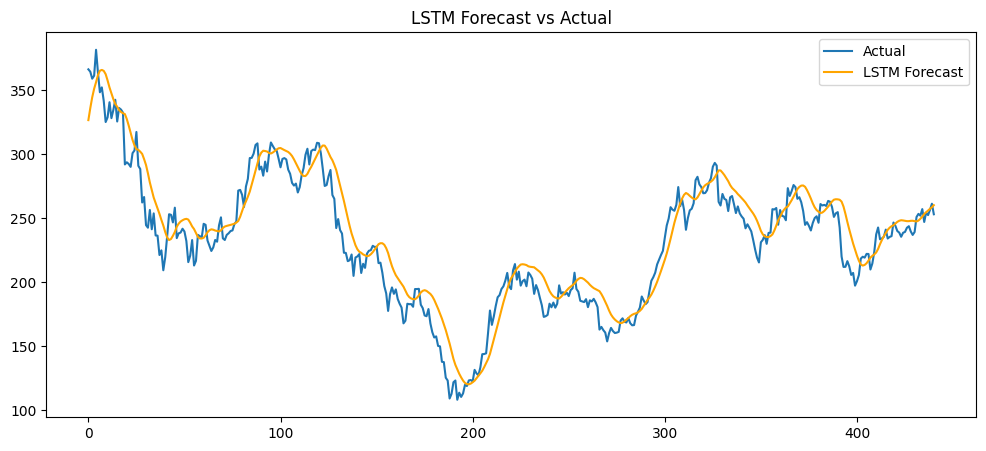

In [16]:
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# Sequence generation
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_close)
split = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Predictions
lstm_preds = model.predict(X_test)
lstm_preds_inv = scaler.inverse_transform(lstm_preds)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(lstm_preds_inv, label='LSTM Forecast', color='orange')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.show()

In [17]:
# Prophet
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds')[-30:]
actual_prophet = prophet_df.set_index('ds')['y'][-30:]
mae_prophet = mean_absolute_error(actual_prophet, prophet_forecast['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(actual_prophet, prophet_forecast['yhat']))

# ARIMA
actual_arima = data['Close'][-30:]
mae_arima = mean_absolute_error(actual_arima, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(actual_arima, arima_forecast))

# SARIMA
mae_sarima = mean_absolute_error(actual_arima, sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(actual_arima, sarima_forecast))

# LSTM
mae_lstm = mean_absolute_error(y_test_inv, lstm_preds_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, lstm_preds_inv))

print("Model Evaluation (Last 30 Days Forecast)")
print(f"Prophet - MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")
print(f"ARIMA   - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"SARIMA  - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")
print(f"LSTM    - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")


Model Evaluation (Last 30 Days Forecast)
Prophet - MAE: 48.08, RMSE: 48.92
ARIMA   - MAE: 10.42, RMSE: 12.22
SARIMA  - MAE: 11.24, RMSE: 12.92
LSTM    - MAE: 13.70, RMSE: 17.10


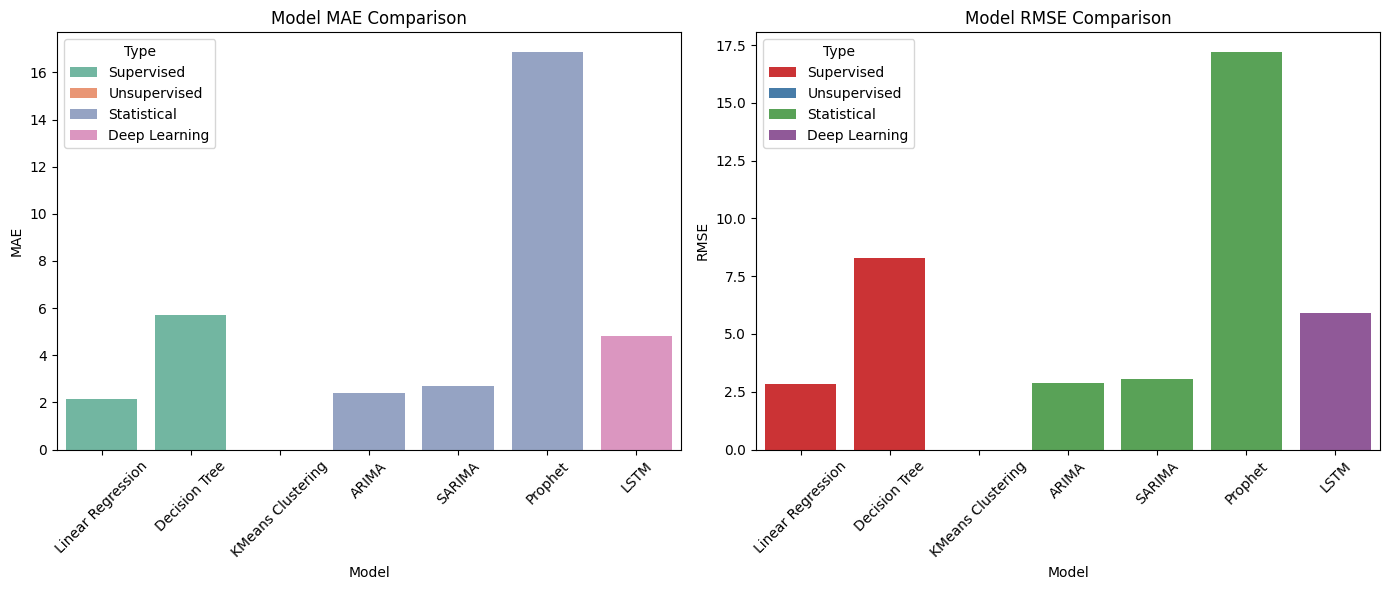

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

performance_data = {
    'Model': [
        'Linear Regression', 'Decision Tree',
        'KMeans Clustering',
        'ARIMA', 'SARIMA', 'Prophet',
        'LSTM'
    ],
    'Type': [
        'Supervised', 'Supervised',
        'Unsupervised',
        'Statistical', 'Statistical', 'Statistical',
        'Deep Learning'
    ],
    'MAE': [2.14, 5.69, None, 2.41, 2.71, 16.86, 4.81],
    'RMSE': [2.82, 8.30, None, 2.87, 3.07, 17.19, 5.90]
}

df_perf = pd.DataFrame(performance_data)

# Plot MAE and RMSE
plt.figure(figsize=(14, 6))

# MAE plot
plt.subplot(1, 2, 1)
sns.barplot(data=df_perf, x='Model', y='MAE', hue='Type', dodge=False, palette='Set2')
plt.title('Model MAE Comparison')
plt.xticks(rotation=45)
plt.ylabel('MAE')
plt.xlabel('Model')

# RMSE plot
plt.subplot(1, 2, 2)
sns.barplot(data=df_perf, x='Model', y='RMSE', hue='Type', dodge=False, palette='Set1')
plt.title('Model RMSE Comparison')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.xlabel('Model')

plt.tight_layout()
plt.show()


Epoch 1/25
56/56 [==============================] - 29s 258ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 2/25
56/56 [==============================] - 14s 248ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 3/25
56/56 [==============================] - 13s 240ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 4/25
56/56 [==============================] - 14s 251ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/25
56/56 [==============================] - 14s 252ms/step - loss: 0.0011 - val_loss: 0.0110
Epoch 6/25
56/56 [==============================] - 15s 262ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 7/25
56/56 [==============================] - 14s 256ms/step - loss: 9.8810e-04 - val_loss: 0.0016
Epoch 8/25
56/56 [==============================] - 15s 266ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 9/25
56/56 [==============================] - 15s 261ms/step - loss: 8.6038e-04 - val_loss: 0.0016
Epoch 10/25
56/56 [==============================] - 15s 261ms/step - loss: 8.4870e

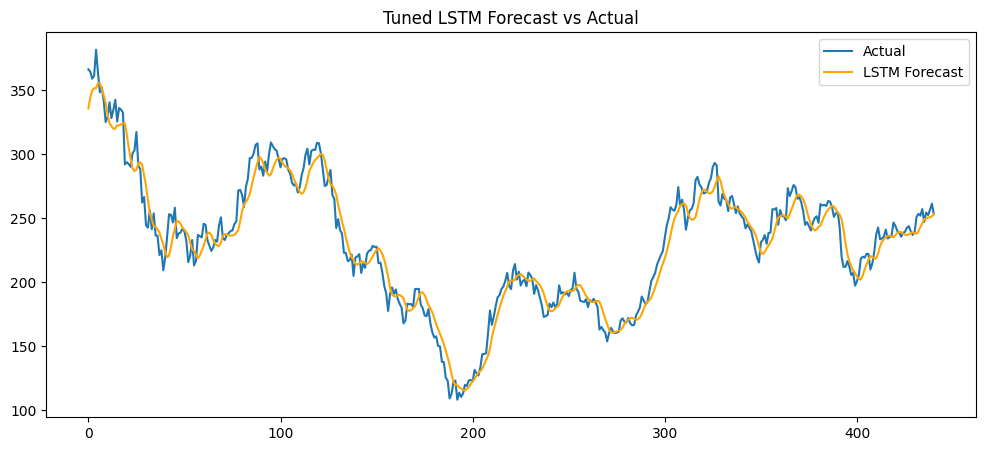

Tuned LSTM - MAE: 9.27, RMSE: 11.68


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Data prep
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# Sequence generation
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_close)

# Reshape for LSTM
X_train, X_test = X_lstm[:int(0.8*len(X_lstm))], X_lstm[int(0.8*len(X_lstm)):]
y_train, y_test = y_lstm[:int(0.8*len(y_lstm))], y_lstm[int(0.8*len(y_lstm)):]

# Build model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=25,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# Predict
lstm_preds = model.predict(X_test)
lstm_preds_inv = scaler.inverse_transform(lstm_preds)
y_test_inv = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(lstm_preds_inv, label='LSTM Forecast', color='orange')
plt.title("Tuned LSTM Forecast vs Actual")
plt.legend()
plt.show()

# Evaluate
mae_lstm = mean_absolute_error(y_test_inv, lstm_preds_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, lstm_preds_inv))

print(f"Tuned LSTM - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 1. Prepare Data
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# 2. Create Sequences
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_close, seq_len=60)

# 3. Train-Test Split
split = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

# 4. Build Bidirectional LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# 5. Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 6. Train Model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=25,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# 7. Predictions
lstm_preds = model.predict(X_test)
lstm_preds_inv = scaler.inverse_transform(lstm_preds)
y_test_inv = scaler.inverse_transform(y_test)

# 8. Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(lstm_preds_inv, label='Bidirectional LSTM Forecast', color='orange')
plt.title("Bidirectional LSTM Forecast vs Actual")
plt.legend()
plt.show()

# 9. Evaluation
mae_bilstm = mean_absolute_error(y_test_inv, lstm_preds_inv)
rmse_bilstm = np.sqrt(mean_squared_error(y_test_inv, lstm_preds_inv))

print(f"📊 Bidirectional LSTM - MAE: {mae_bilstm:.2f}, RMSE: {rmse_bilstm:.2f}")


Epoch 1/25
56/56 [==============================] - 46s 369ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 2/25
56/56 [==============================] - 15s 270ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 3/25
56/56 [==============================] - 16s 292ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 4/25
56/56 [==============================] - 16s 286ms/step - loss: 9.9761e-04 - val_loss: 0.0026
Epoch 5/25
56/56 [==============================] - 17s 304ms/step - loss: 8.6713e-04 - val_loss: 0.0018
Epoch 6/25
56/56 [==============================] - 16s 294ms/step - loss: 7.3296e-04 - val_loss: 0.0021
Epoch 7/25
56/56 [==============================] - 17s 300ms/step - loss: 7.4964e-04 - val_loss: 0.0012
Epoch 8/25
56/56 [==============================] - 17s 300ms/step - loss: 9.0586e-04 - val_loss: 0.0013
Epoch 9/25
56/56 [==============================] - 17s 304ms/step - loss: 7.2918e-04 - val_loss: 0.0012
Epoch 10/25
56/56 [==============================] - 17s 296ms/step

In [ ]:
#  Forecast Next 30 Days
forecast_days = 30
last_60_days = scaled_close[-60:]  # shape: (60, 1)
future_preds = []

input_seq = last_60_days.copy()

for _ in range(forecast_days):
    input_reshaped = input_seq.reshape(1, 60, 1)
    pred = model.predict(input_reshaped, verbose=0)
    future_preds.append(pred[0, 0])
    input_seq = np.append(input_seq[1:], [[pred[0, 0]]], axis=0)  # move window

# Inverse scale the predictions
future_preds = np.array(future_preds).reshape(-1, 1)
future_preds_inv = scaler.inverse_transform(future_preds)

# 11. Plot Future Predictions
plt.figure(figsize=(12, 5))
plt.plot(range(len(close_prices)), close_prices, label='Historical Close')
plt.plot(range(len(close_prices), len(close_prices) + forecast_days), future_preds_inv, label='Next 30 Days Forecast', color='green')
plt.title("Bidirectional LSTM - 30-Day Forecast")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Convert actual historical close prices to DataFrame
actual_dates = pd.date_range(end=data.index[-1], periods=len(close_prices))
actual_df = pd.DataFrame({
    'Date': actual_dates,
    'Price': close_prices.flatten(),
    'Type': 'Actual'
})

# Create future dates for forecast
future_dates = pd.date_range(start=actual_dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Price': future_preds_inv.flatten(),
    'Type': 'Forecast'
})

# Combine both
combined_df = pd.concat([actual_df, forecast_df], ignore_index=True)

# Save to CSV
combined_df.to_csv("lstm_forecast_30days.csv", index=False)

print("✅ Saved to lstm_forecast_30days.csv")


In [ ]:
%%writefile streamlit_app.py
import streamlit as st
import pandas as pd
import altair as alt

st.set_page_config(page_title="📈 Tesla Forecast Dashboard", layout="wide")
st.title(" 🚗Tesla Stock Price 30 days Forecast Dashboard")

# Load data
data = pd.read_csv("lstm_forecast_30days.csv", parse_dates=["Date"])
data.set_index("Date", inplace=True)
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
data.dropna(subset=["Price"], how="all", inplace=True)

# Date Range Filter
st.sidebar.header("📅 Filter by Date")
min_date = data.index.min().date()
max_date = data.index.max().date()
start_date = st.sidebar.date_input("Start Date", min_value=min_date, max_value=max_date, value=min_date)
end_date = st.sidebar.date_input("End Date", min_value=min_date, max_value=max_date, value=max_date)

if start_date >= end_date:
    st.error("⚠️ End date must be after start date.")
    st.stop()

data_filtered = data.loc[str(start_date):str(end_date)]

# Forecast Point Selector
st.sidebar.header("🎯 Highlight Forecast Point")
forecast_only = data_filtered[data_filtered['Type'] == 'Forecast']
forecast_only = forecast_only['Price'].dropna()
forecast_date = None
selected_price = None

if not forecast_only.empty:
    forecast_date_input = st.sidebar.slider(
        "Select Date on Forecast Line",
        min_value=forecast_only.index.min().date(),
        max_value=forecast_only.index.max().date(),
        value=forecast_only.index.min().date(),
        format="YYYY-MM-DD"
    )
    forecast_date = pd.to_datetime(forecast_date_input)
    if forecast_date in forecast_only.index:
        selected_price = forecast_only.loc[forecast_date]
        st.sidebar.write(f"Forecast Price on {forecast_date.date()}: **${selected_price:.2f}**")

# Plotting
df_chart = data_filtered.reset_index().melt(
    id_vars=['Date', 'Type'],
    value_vars=['Price'],
    var_name='ValueType',
    value_name='Value'
).dropna(subset=['Value'])

chart = alt.Chart(df_chart).mark_line().encode(
    x=alt.X('Date:T', title='Date'),
    y=alt.Y('Value:Q', title='Price'),
    color='Type:N',
    tooltip=['Date:T', alt.Tooltip('Value:Q', title='Price'), 'Type:N']
).properties(
    title="Stock Price: Actual vs Forecast"
).interactive()

if forecast_date and selected_price is not None:
    highlight_point = alt.Chart(pd.DataFrame({
        'Date': [forecast_date],
        'Value': [selected_price],
        'Type': ['Forecast']
    })).mark_circle(size=100, color='red').encode(
        x='Date:T',
        y='Value:Q',
        tooltip=[alt.Tooltip('Date:T'), alt.Tooltip('Value:Q', title='Selected Forecast Price')]
    )
    chart += highlight_point

st.altair_chart(chart, use_container_width=True)

# Show raw data
if st.checkbox("Show raw data"):
    st.dataframe(data_filtered)
